In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-03-19 17:32:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 209.85.145.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-03-19 17:32:34 (78.1 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



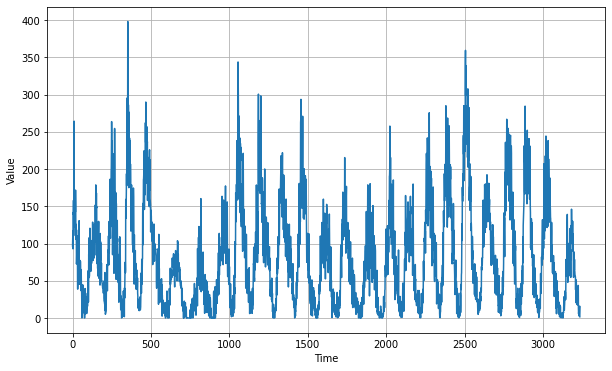

In [ ]:
import csv

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                                                           strides=1, padding="causal",
                                                           activation="relu",
                                                           input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 290ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 4s 287ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 4s 290ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 4s 287ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 4s 290ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 4s 292ms/step - loss: 62.9767 - mae: 63.4739
Epoch 7/100
12/12 [==============================] - 4s 285ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 4s 287ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 4s 290ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/

(1e-08, 0.0001, 0.0, 60.0)

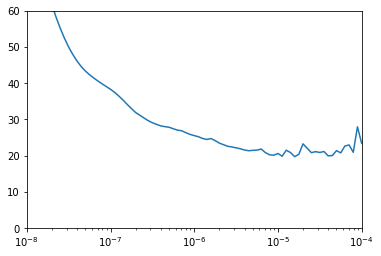

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                                                           strides=1, padding="causal",
                                                           activation="relu",
                                                           input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/500
12/12 [==============================] - 7s 286ms/step - loss: 53.9832 - mae: 54.4802
Epoch 2/500
12/12 [==============================] - 4s 286ms/step - loss: 29.4427 - mae: 29.9383
Epoch 3/500
12/12 [==============================] - 4s 284ms/step - loss: 25.9672 - mae: 26.4622
Epoch 4/500
12/12 [==============================] - 4s 287ms/step - loss: 23.4108 - mae: 23.9050
Epoch 5/500
12/12 [==============================] - 4s 287ms/step - loss: 21.5617 - mae: 22.0554
Epoch 6/500
12/12 [==============================] - 4s 288ms/step - loss: 20.9021 - mae: 21.3954
Epoch 7/500
12/12 [==============================] - 4s 287ms/step - loss: 20.5285 - mae: 21.0216
Epoch 8/500
12/12 [==============================] - 4s 285ms/step - loss: 20.1822 - mae: 20.6755
Epoch 9/500
12/12 [==============================] - 4s 290ms/step - loss: 19.5063 - mae: 19.9991
Epoch 10/500
12/

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

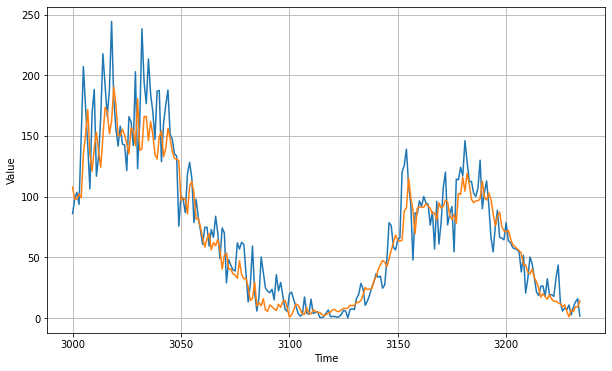

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.08859

<Figure size 432x288 with 0 Axes>

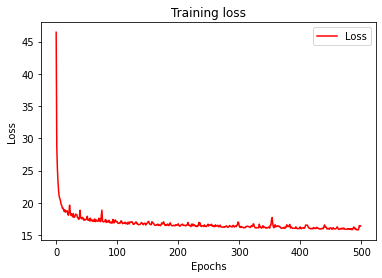

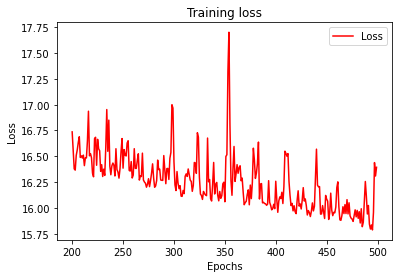

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[107.8139      98.081825    97.87645    102.18406     98.95041
 134.82443    151.37343    171.63126    135.60544    120.923805
 139.73264    153.06277    137.26222    124.2325     149.6616
 173.45776    170.25487    151.80185    161.92635    190.19142
 175.84482    150.16553    150.25238    155.46678    150.56253
 143.68735    135.14484    156.56738    154.21114    141.88097
 180.59076    138.06499    139.3042     165.95554    165.97546
 146.1186     161.78754    151.46912    135.10431    131.04483
 149.27017    153.77829    132.91805    139.62659    156.22191
 147.78333    137.40292    131.47906    131.0888     129.35172
  96.80402     99.04224     97.74749     85.70844    108.583534
 112.42366    102.88285     81.44282     82.22426     74.69096
  65.79771     58.316803    65.366806    69.629005    56.181633
  62.128086    59.492905    64.751595    56.642544    40.29925
  51.50606     53.44822     40.326847    40.48399     36.180973
  35.485443    32.69571     47.141136    35.527325  